# Clustering

The different approaches to perform clustering are

- Connectivity-based clustering where observations are recursively linked together
- Centroid-based clustering where clusters are represented by a centroid
- Distribution-based clustering where clusters are assumed to be sampled from statistical well-known distributions
- Density-based clustering where dense regions of points are grouped together

For more perspective see [here](http://scikit-learn.org/stable/modules/clustering.html).

In [1]:
%matplotlib notebook

## K-means

In [2]:
import pandas as pd
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])

X.head()

,Sepal length,Sepal width,Petal length,Petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


<IPython.core.display.Javascript object>


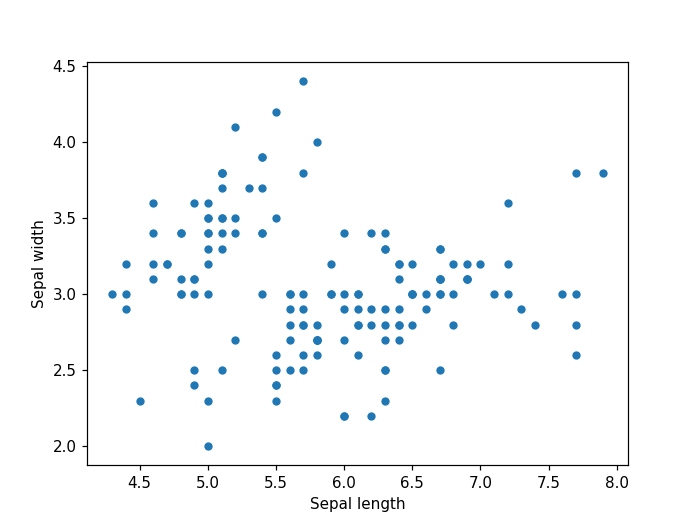

In [3]:
X.plot.scatter(x='Sepal length', y='Sepal width');

### Explanation

Lloyd's algorithm goes as follows:

1. Generate random centroids.
2. Assign each point to the closest centroid.
3. Move each centroid to the average of the points that are assigned to it.
4. Repeat from step 2 until a termination criterion is reached.

### With scikit-learn

<IPython.core.display.Javascript object>


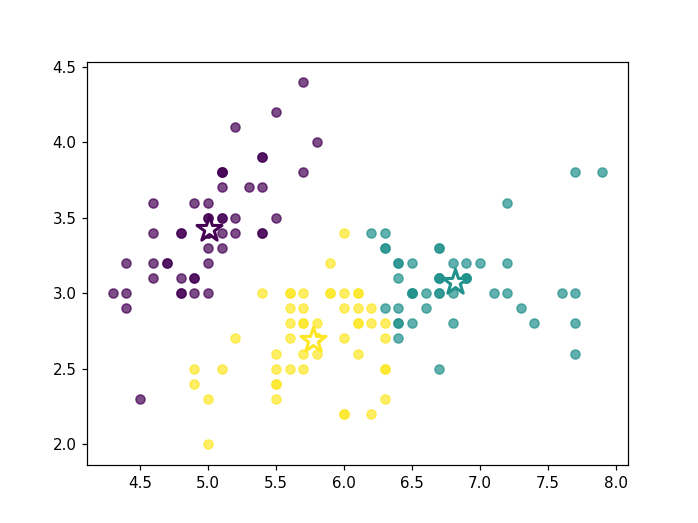

In [22]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import cluster


k = 3 
kmeans = cluster.KMeans(n_clusters=k, random_state=42)
kmeans.fit(X[['Sepal length', 'Sepal width']])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_ 

fig, ax = plt.subplots()
colors = iter(cm.viridis(np.linspace(0, 1, k)))

for i, centroid in enumerate(centroids):
    color = next(colors)
    
    # Plot the points
    x = [xi[0] for xi in X[labels == i].values]
    y = [xi[1] for xi in X[labels == i].values]
    ax.scatter(x, y, color=color, alpha=0.7)
    
    # Plot the centroids
    ax.scatter(centroid[0], centroid[1], color='white', marker='*', s=300,
               edgecolor=color, linewidth='2')
    

### Ourselves

Let's write a simple version of Lloyd's algorithm.

<IPython.core.display.Javascript object>


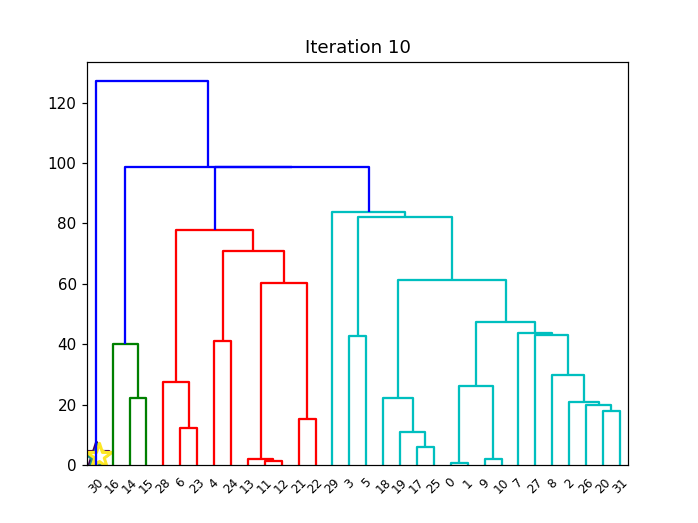

In [24]:
import time

import numpy as np


def l1_distance(x, y):
    return np.abs(x - y).sum()


def k_means(X, k=3, distance=l1_distance, n_iterations=10, ax=None):
    
    # Make sure we're working with a numpy.ndarray and not a pandas.DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Create the initial centroids at random
    row_means = X.mean(axis=0)
    centroids = [np.random.uniform(0.5, 1.5, size=len(row_means)) * row_means for _ in range(k)]
    
    for i in range(n_iterations):
        
        # We'll store the clusters inside a dictionary
        clusters = {i: [] for i in range(k)}
        
        # Iterate over each data point 
        for j, x in enumerate(X):
            
            # Compute the distance with each centroid
            distances = [distance(x, centroid) for centroid in centroids]
            
            # Find the closest centroid
            closest = np.argmin(distances)
            clusters[closest].append(j)
    
        # Update each centroid
        for j, points in clusters.items():
            
            # No update is needed if there are no points assigned
            if not points:
                continue
            
            # The centroid becomes the average of the points in the clusters it forms 
            centroid = np.mean([X[k] for k in points], axis=0)
            centroids[j] = centroid
    
        # Plot the current disposition
        if ax:
            colors = iter(cm.viridis(np.linspace(0, 1, k)))
            ax.clear()
            ax.set_title('Iteration {}'.format(i+1))
            
            for i, centroid in enumerate(centroids):
                
                # Use the same color for the point and the centroids
                color = next(colors)
                
                # Plot the points belonging to the centroid
                cluster = clusters[i]
                x = [X[j][0] for j in cluster]
                y = [X[j][1] for j in cluster]
                ax.scatter(x, y, color=color, alpha=0.7)
                
                # Plot the centroid
                ax.scatter(centroid[0], centroid[1], color='white', marker='*', s=300,
                           edgecolor=color, linewidth='2')
            
            fig.canvas.draw()
            time.sleep(0.3)
        
    return centroids, clusters


fig, ax = plt.subplots()
plt.ion()
    
centroids, clusters = k_means(X[['Sepal length', 'Sepal width']], k=3, ax=ax)

## Hierarchical clustering

### Explanation

There are two types of hierarchical clustering:

- Agglomerative where we start with one cluster per observation and merge recursively
- Divisive where we start with one cluster and break it down recursively

There are two components:

1. A metric which calculates a distance between two points.
2. A linkage criterion which computes a distance between two clusters given their pair-wise distances obtained with the metric.

Some simple linkage criteria are:

- Maximum linkage: $max\{d(a, b); a \in A\, b \in B\}$
- Minimum linkage: $min\{d(a, b); a \in A\, b \in B\}$
- Average linkage: $\frac{1}{|A| \times |B|} \sum_{a \in A} \sum_{b \in B} d(a, b)$

You can find more linkage criteria [here](https://www.wikiwand.com/en/Hierarchical_clustering#/Linkage_criteria).

### With scipy

See [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

<IPython.core.display.Javascript object>


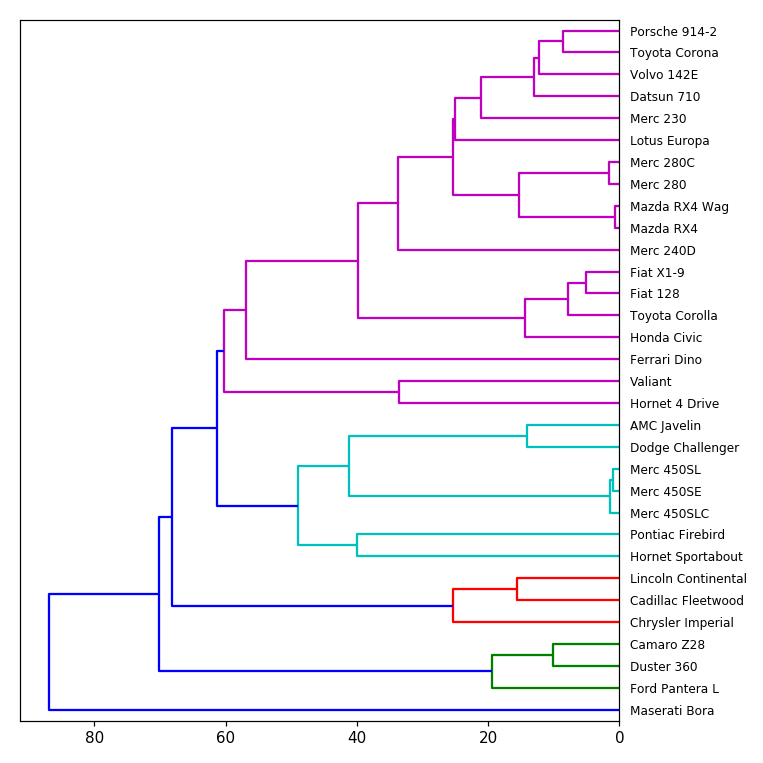

In [63]:
from scipy.cluster import hierarchy


linkage = hierarchy.linkage(df, 'single')

fig = plt.figure(figsize=(7, 7))
hierarchy.dendrogram(linkage, labels=df.index, orientation='left')
plt.tight_layout();
plt.show();

### Ourselves

<IPython.core.display.Javascript object>


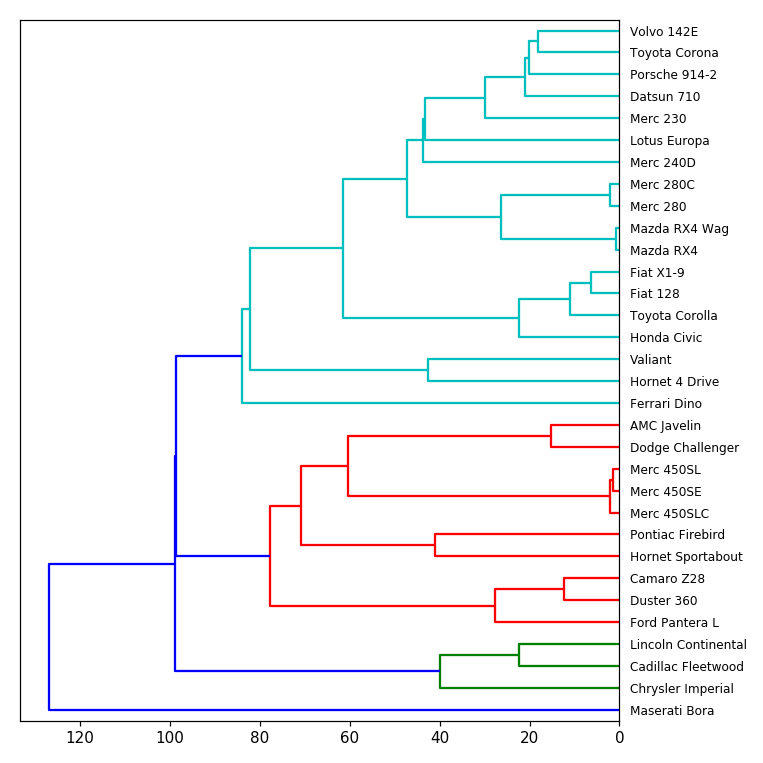

In [58]:
import itertools


def hac(X, metric=l1_distance):
    """HAC stands for Hierarchical Agglomerative Clustering.
    
    In this implementation we use minimum linkage criterion.
    """
    
    # Make sure we're working with a numpy.ndarray and not a pandas.DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # We will store the clusters in a dictionary of lists
    clusters = {i: [i] for i, _ in enumerate(X)}
    
    # We will also store the linkage history for plotting purposes
    linkage = []
    
    # Compute each pairwise distance
    n = len(clusters)
    distances = np.zeros(shape=(n, n)) + np.inf
    for i in range(n):
        for j in range(i+1, n):
            dist = metric(X[i], X[j])
            distances[i, j] = dist
            distances[j, i] = dist
            
    while len(clusters) > 1:
        
        # We're looking for the two closest clusters, denoted a and b
        a, b = None, None
        min_dist = np.inf
        
        for i, j in itertools.combinations(clusters.keys(), 2):
                
            # Search for the smallest pairwise between both clusters
            dist = min(metric(X[k], X[l]) for k in clusters[i] for l in clusters[j])

            # Check if the smallest distance is lower than the current lowest distance
            if dist < min_dist:
                a, b = i, j
                min_dist = dist
        
        # Merge the two closest clusters
        clusters[n] = clusters.pop(a) + clusters.pop(b)
                
        # Update the linkage matrix
        linkage.append([a, b, min_dist, len(clusters[n])])
        
        n += 1
        
    return linkage
    
linkage = hac(df)

fig = plt.figure(figsize=(7, 7))
hierarchy.dendrogram(linkage, labels=df.index, orientation='left')
plt.tight_layout();
plt.show();